In [2]:
import requests
import nltk
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:

# Step 1: Scrape the cryptocurrency headlines
url = "https://crypto.news/?s=xrp"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# Extract headlines from h3 tags
headlines = [h3.get_text() for h3 in soup.find_all("h3")]

# Step 2: Perform sentiment analysis using VADER and TextBlob
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Student\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:

data = []
for headline in headlines:
    # VADER sentiment analysis
    vader_score = sia.polarity_scores(headline)["compound"]

    # TextBlob sentiment analysis
    textblob_score = TextBlob(headline).sentiment.polarity

    data.append(
        {
            "headline": headline,
            "vader_score": vader_score,
            "textblob_score": textblob_score,
        }
    )

print("VADER Sentinment Analysis:")
print(vader_score)

print("\nTextBlob Sentinment Analysis:")
print(f"Polarity : {TextBlob(headline).sentiment.polarity}, Subjectivity {TextBlob(headline).sentiment.polarity}")





VADER Sentinment Analysis:
0.0

TextBlob Sentinment Analysis:
Polarity : 0.0, Subjectivity 0.0


In [ ]:

data = []
for headline in headlines:
    # VADER sentiment analysis
    vader_score = sia.polarity_scores(headline)["compound"]

    # TextBlob sentiment analysis
    textblob_score = TextBlob(headline).sentiment.polarity

    data.append(
        {
            "headline": headline,
            "vader_score": vader_score,
            "textblob_score": textblob_score,
        }
    )

print("VADER Sentinment Analysis:")
print(vader_score)

print("\nTextBlob Sentinment Analysis:")
print(f"Polarity : {TextBlob(headline).sentiment.polarity}, Subjectivity {TextBlob(headline).sentiment.polarity}")





VADER Sentinment Analysis:
0.0

TextBlob Sentinment Analysis:
Polarity : 0.0, Subjectivity 0.0


In [ ]:

data = []
for headline in headlines:
    # VADER sentiment analysis
    vader_score = sia.polarity_scores(headline)["compound"]

    # TextBlob sentiment analysis
    textblob_score = TextBlob(headline).sentiment.polarity

    data.append(
        {
            "headline": headline,
            "vader_score": vader_score,
            "textblob_score": textblob_score,
        }
    )

print("VADER Sentinment Analysis:")
print(vader_score)

print("\nTextBlob Sentinment Analysis:")
print(f"Polarity : {TextBlob(headline).sentiment.polarity}, Subjectivity {TextBlob(headline).sentiment.polarity}")





VADER Sentinment Analysis:
0.0

TextBlob Sentinment Analysis:
Polarity : 0.0, Subjectivity 0.0


In [ ]:

data = []
for headline in headlines:
    # VADER sentiment analysis
    vader_score = sia.polarity_scores(headline)["compound"]

    # TextBlob sentiment analysis
    textblob_score = TextBlob(headline).sentiment.polarity

    data.append(
        {
            "headline": headline,
            "vader_score": vader_score,
            "textblob_score": textblob_score,
        }
    )

print("VADER Sentinment Analysis:")
print(vader_score)

print("\nTextBlob Sentinment Analysis:")
print(f"Polarity : {TextBlob(headline).sentiment.polarity}, Subjectivity {TextBlob(headline).sentiment.polarity}")





VADER Sentinment Analysis:
0.0

TextBlob Sentinment Analysis:
Polarity : 0.0, Subjectivity 0.0


In [ ]:

# Step 3: Create a DataFrame
df = pd.DataFrame(data)


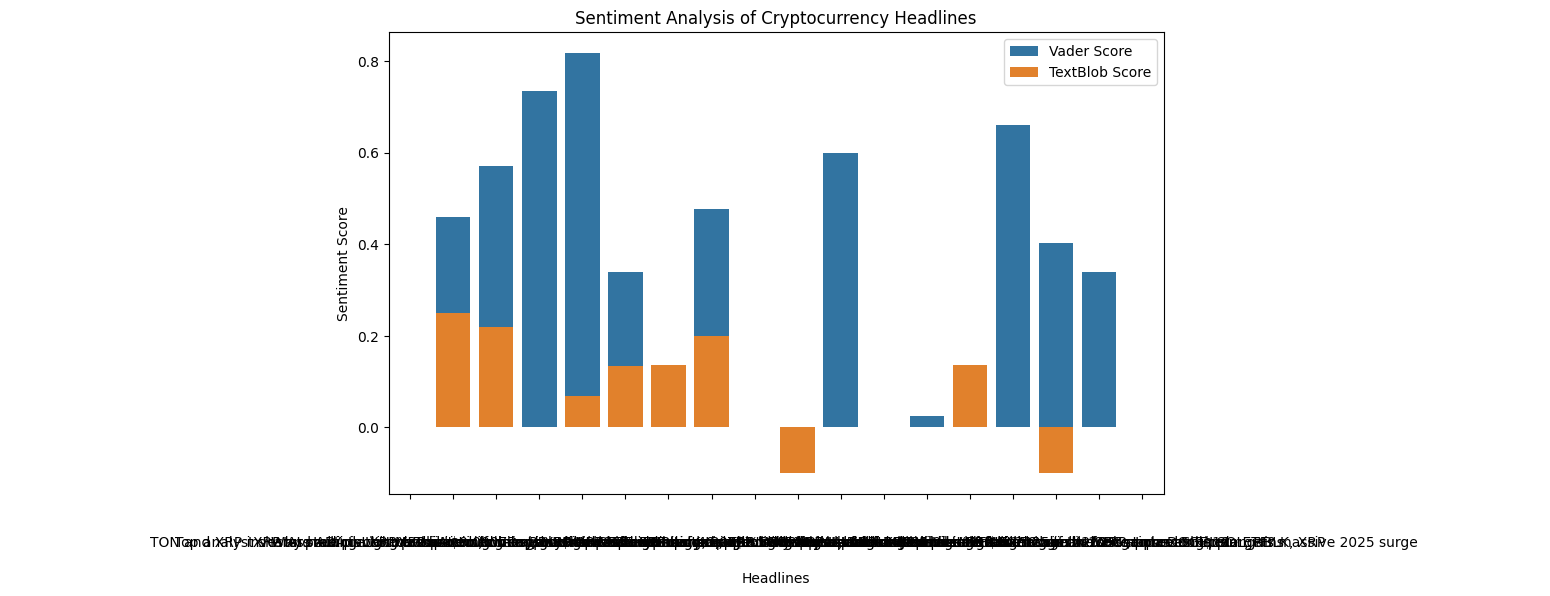

In [5]:

# Step 4: Plot the results using Seaborn
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the results using seaborn
sns.barplot(x="headline", y="vader_score", data=df, label="Vader Score", ax=ax)
sns.barplot(x="headline", y="textblob_score", data=df, label="TextBlob Score", ax=ax)

# Set title and labels
ax.set_title("Sentiment Analysis of Cryptocurrency Headlines")
ax.set_xlabel("Headlines")
ax.set_ylabel("Sentiment Score")

# Add legend
ax.legend()
